In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
import json
import os
from sklearn.model_selection import train_test_split

import sys
sys.path.append('/Users/jacobzwoniarski/Desktop/qae_architectures')

from qae_utils.Files import read_ts_file, read_json_file

print("Imports successful!")

Imports successful!


In [ ]:
# Load the Mackey-Glass data
DATA_PATH = 'aintern/data'
DATA_NAME = 'mackey_glass'

try:
    data_folders = [f for f in os.listdir(DATA_PATH) if f.startswith(DATA_NAME)]
    if not data_folders:
        raise FileNotFoundError("No Mackey-Glass data found. Please run the data generation notebook first.")
    
    data_folder = data_folders[0]
    print(f"Using data from: {data_folder}")
    
    X = read_ts_file(f'{DATA_PATH}/{data_folder}/x_org.arr')
    y = read_ts_file(f'{DATA_PATH}/{data_folder}/y_org.arr')
    info = read_json_file(f'{DATA_PATH}/{data_folder}/info.json')
    
    print(f"Loaded {len(y)} samples")
    print(f"Data range: [{np.min(y):.3f}, {np.max(y):.3f}]")
    print(f"Scale info: low={info['scale_low']}, high={info['scale_high']}")
    
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please make sure you've run the data generation notebook first.")

Using data from: mackey_glass_n100
Loaded 100 samples
Data range: [0.230, 0.789]
Scale info: low=0.2, high=0.8


In [ ]:
# Half-QAE Architecture Parameters
n_qubits = 4     # Total qubits
n_latent = 2     
n_trash = n_qubits - n_latent 

print(f"QAE Architecture:")
print(f"- Total qubits: {n_qubits}")
print(f"- Latent space: {n_latent} qubits")  
print(f"- Trash space: {n_trash} qubits")

# Create quantum device
dev = qml.device('default.qubit', wires=n_qubits)

QAE Architecture:
- Total qubits: 4
- Latent space: 2 qubits
- Trash space: 2 qubits


In [187]:
# Define the Half-QAE Circuit
# def encoder_circuit(params, x):
#     """Enhanced Encoder with better temporal encoding and entanglement"""
    
#     # 1. Enhanced angle encoding with multiple rotations
#     for i, val in enumerate(x[:n_qubits]):
#         # Scale data to different rotation ranges for better expressivity
#         qml.RY(val * np.pi, wires=i)        # Y rotation
#         qml.RZ(val * np.pi * 0.5, wires=i)  # Z rotation (different scale)
#         qml.RX(val * np.pi * 0.3, wires=i)  # X rotation (different scale)
    
#     # 2. Variational layers with improved entanglement
#     n_layers = len(params) // (n_qubits * 3)
#     for layer in range(n_layers):
#         # Parameterized rotation gates
#         for i in range(n_qubits):
#             idx = layer * n_qubits * 3 + i * 3
#             qml.RX(params[idx], wires=i)
#             qml.RY(params[idx + 1], wires=i)
#             qml.RZ(params[idx + 2], wires=i)
        
#         # Enhanced entanglement patterns
#         # Linear chain
#         for i in range(n_qubits - 1):
#             qml.CNOT(wires=[i, i + 1])
        
#         # All-to-all connections (for better information mixing)
#         if n_qubits <= 6:  # Only for small systems to avoid too many gates
#             for i in range(n_qubits):
#                 for j in range(i + 2, n_qubits):  # Skip adjacent (already connected)
#                     qml.CNOT(wires=[i, j])
        
#         # Periodic boundary
#         qml.CNOT(wires=[n_qubits - 1, 0])
        
#         # Add controlled-Z gates for different entanglement patterns
#         for i in range(0, n_qubits - 1, 2):
#             qml.CZ(wires=[i, i + 1])
# def decoder_circuit(params):
#     """Enhanced Decoder with better reconstruction capability"""
#     n_layers = len(params) // (n_qubits * 3)
    
#     for layer in range(n_layers):
#         # Parameterized rotation gates
#         for i in range(n_qubits):
#             idx = layer * n_qubits * 3 + i * 3
#             qml.RX(params[idx], wires=i)
#             qml.RY(params[idx + 1], wires=i)
#             qml.RZ(params[idx + 2], wires=i)
        
#         # Enhanced entanglement (similar to encoder)
#         for i in range(n_qubits - 1):
#             qml.CNOT(wires=[i, i + 1])
            
#         # Reverse connectivity pattern
#         for i in range(n_qubits - 1, 0, -1):
#             qml.CNOT(wires=[i, i - 1])
            
#         # Periodic boundary
#         qml.CNOT(wires=[n_qubits - 1, 0])
        
#         # Add some CZ gates
#         for i in range(1, n_qubits - 1, 2):
#             qml.CZ(wires=[i, i + 1])
# REVERT TO SIMPLE WORKING VERSION
def encoder_circuit(params, x):
    # 1. Simple angle encoding
    for i, val in enumerate(x[:n_qubits]):
        qml.RY(val * np.pi, wires=i)
    
    # 2. Simple variational layers
    n_layers = len(params) // (n_qubits * 3)
    for layer in range(n_layers):
        for i in range(n_qubits):
            idx = layer * n_qubits * 3 + i * 3
            qml.RX(params[idx], wires=i)
            qml.RY(params[idx + 1], wires=i)
            qml.RZ(params[idx + 2], wires=i)
        
        # Simple entanglement
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        qml.CNOT(wires=[n_qubits - 1, 0])

def decoder_circuit(params):
    n_layers = len(params) // (n_qubits * 3)
    
    for layer in range(n_layers):
        # Reverse entanglement
        qml.CNOT(wires=[n_qubits - 1, 0])
        for i in range(n_qubits - 2, -1, -1):
            qml.CNOT(wires=[i + 1, i])
        
        # Rotations
        for i in range(n_qubits):
            idx = layer * n_qubits * 3 + i * 3
            qml.RZ(params[idx + 2], wires=i)
            qml.RY(params[idx + 1], wires=i)
            qml.RX(params[idx], wires=i)

# BACK TO SIMPLE Z MEASUREMENTS ONLY
@qml.qnode(dev, diff_method="backprop")
def half_qae_circuit(enc_params, dec_params, x):
    encoder_circuit(enc_params, x)
    decoder_circuit(dec_params)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

print(" simple working circuit!")

 simple working circuit!


In [ ]:
# Prepare training data with sliding windows
window_size = n_qubits
stride = 1

print(f"Creating sliding windows...")
print(f"Window size: {window_size}")
print(f"Stride: {stride}")

X_windows = []
for i in range(0, len(y) - window_size + 1, stride):
    window = y[i:i + window_size]
    X_windows.append(window)

X_windows = np.array(X_windows)
print(f"Created {len(X_windows)} training windows")

# Split into train/validation/test
X_temp, X_test = train_test_split(X_windows, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 of total

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")  
print(f"Test samples: {len(X_test)}")

# Show a sample
print(f"\nSample training window: {X_train[0]}")

Creating sliding windows...
Window size: 4
Stride: 1
Created 97 training windows
Training samples: 57
Validation samples: 20
Test samples: 20

Sample training window: [0.30838322 0.32181567 0.30554626 0.306231  ]


In [186]:
#TRAINING SETTINGS
n_epochs = 100
batch_size = 8  
learning_rate = 0.01
n_layers = 2

np.random.seed(42)
init_scale = 0.0
enc_param_shape = n_layers * n_qubits * 3
dec_param_shape = n_layers * n_qubits * 3

enc_params = pnp.array(np.random.uniform(-init_scale, init_scale, enc_param_shape), requires_grad=True)
dec_params = pnp.array(np.random.uniform(-init_scale, init_scale, dec_param_shape), requires_grad=True)

print(f"Conservative settings: {n_layers} layers, LR={learning_rate}, init_scale={init_scale}")

Conservative settings: 2 layers, LR=0.01, init_scale=0.0


In [188]:
# SIMPLE MSE COST FUNCTION
def simple_reconstruction_cost(enc_params, dec_params, X_batch):
    total_cost = 0.0
    
    for x in X_batch:
        output_raw = half_qae_circuit(enc_params, dec_params, x)
        
        # Scale output
        output_scaled = []
        for o in output_raw:
            o_val = float(o) if hasattr(o, 'numpy') else o
            scaled = (o_val + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low']
            output_scaled.append(scaled)
        
        output_scaled = pnp.array(output_scaled)
        x_tensor = pnp.array(x)
        
        # Just MSE - keep it simple!
        mse = pnp.mean((x_tensor - output_scaled)**2)
        total_cost += mse
    
    return total_cost / len(X_batch)

# Use simple cost
reconstruction_cost = simple_reconstruction_cost
print("simple MSE cost function!")

simple MSE cost function!


In [ ]:
# Alternative Training Loop - Using step_and_cost correctly
def train_half_qae_v2(initial_enc_params, initial_dec_params):
    """Complete training loop for the replicating half-QAE - Version 2"""
    
    # Create a single parameter vector for the optimizer
    def cost_wrapper(params):
        # Split the parameter vector
        enc_size = len(initial_enc_params)
        dec_size = len(initial_dec_params)
        enc_p = params[:enc_size]
        dec_p = params[enc_size:]
        
        return reconstruction_cost(enc_p, dec_p, current_batch)
    
    # Combine parameters into single vector
    combined_params = pnp.concatenate([initial_enc_params, initial_dec_params])
    
    # Initialize optimizer
    opt = qml.AdamOptimizer(stepsize=learning_rate)
    
    # Training history
    train_costs = []
    val_costs = []
    
    print("Starting Half-QAE Training (Version 2)...")
    print("=" * 50)
    
    global current_batch  # Make batch accessible to cost_wrapper
    
    for epoch in range(n_epochs):
        # Shuffle training data
        indices = np.random.permutation(len(X_train))
        
        epoch_cost = 0.0
        n_batches = 0
        
        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            batch_indices = indices[i:i + batch_size]
            current_batch = X_train[batch_indices]
            
            # Update parameters
            combined_params, cost = opt.step_and_cost(cost_wrapper, combined_params)
            
            epoch_cost += float(cost)
            n_batches += 1
        
        # Calculate average training cost
        avg_train_cost = epoch_cost / n_batches
        train_costs.append(avg_train_cost)
        
        # Validation cost (every 10 epochs)
        if epoch % 10 == 0:
            enc_size = len(initial_enc_params)
            enc_p = combined_params[:enc_size]
            dec_p = combined_params[enc_size:]
            val_cost = reconstruction_cost(enc_p, dec_p, X_val[:50])
            val_cost_float = float(val_cost)
            val_costs.append(val_cost_float)
            print(f"Epoch {epoch:3d}: Train Cost = {avg_train_cost:.6f}, Val Cost = {val_cost_float:.6f}")
        
        # Early stopping check
        if epoch > 20 and avg_train_cost < 1e-6:
            print(f"Early stopping at epoch {epoch} - excellent reconstruction achieved!")
            break
    
    print("=" * 50)
    print("Training completed!")
    
    # Split final parameters
    enc_size = len(initial_enc_params)
    final_enc_params = combined_params[:enc_size]
    final_dec_params = combined_params[enc_size:]
    
    return final_enc_params, final_dec_params, train_costs, val_costs

# Run training
enc_params_trained, dec_params_trained, train_history, val_history = train_half_qae_v2(enc_params, dec_params)

Starting Half-QAE Training (Version 2)...
Epoch   0: Train Cost = 0.039428, Val Cost = 0.030211
Epoch  10: Train Cost = 0.006343, Val Cost = 0.004539
Epoch  20: Train Cost = 0.002652, Val Cost = 0.002035
Epoch  30: Train Cost = 0.001561, Val Cost = 0.001139
Epoch  40: Train Cost = 0.001126, Val Cost = 0.000805
Epoch  50: Train Cost = 0.000816, Val Cost = 0.000705
Epoch  60: Train Cost = 0.000631, Val Cost = 0.000583
Epoch  70: Train Cost = 0.000671, Val Cost = 0.000457
Epoch  80: Train Cost = 0.000573, Val Cost = 0.000435
Epoch  90: Train Cost = 0.000417, Val Cost = 0.000374
Training completed!


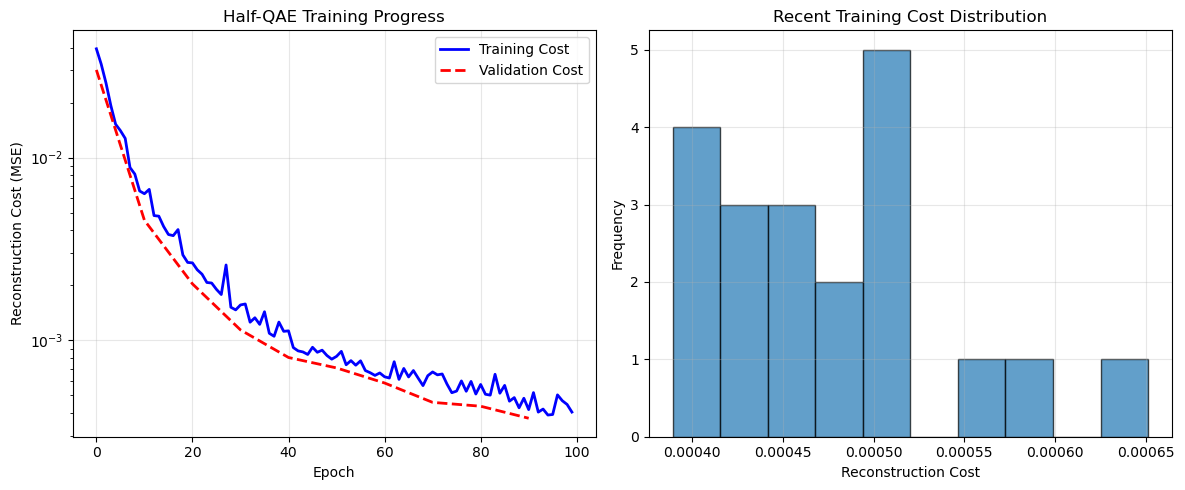

Final training cost: 0.00040434
Final validation cost: 0.00037403


In [ ]:
# Visualization of Training Progress
def plot_training_progress(train_costs, val_costs):
    """Plot training and validation costs"""
    
    plt.figure(figsize=(12, 5))
    
    # Training progress
    plt.subplot(1, 2, 1)
    plt.plot(train_costs, label='Training Cost', linewidth=2, color='blue')
    if val_costs:
        val_epochs = list(range(0, len(val_costs) * 10, 10))
        plt.plot(val_epochs, val_costs, 'r--', label='Validation Cost', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Reconstruction Cost (MSE)')
    plt.title('Half-QAE Training Progress')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Final cost distribution
    plt.subplot(1, 2, 2)
    recent_costs = train_costs[-20:] if len(train_costs) >= 20 else train_costs
    if len(recent_costs) > 1:
        plt.hist(recent_costs, bins=min(10, len(recent_costs)), alpha=0.7, edgecolor='black')
        plt.xlabel('Reconstruction Cost')
        plt.ylabel('Frequency')
        plt.title('Recent Training Cost Distribution')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Not enough data\nfor histogram', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Recent Training Cost Distribution')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final training cost: {train_costs[-1]:.8f}")
    if val_costs:
        print(f"Final validation cost: {val_costs[-1]:.8f}")

# Plot the training progress
plot_training_progress(train_history, val_history)

Testing Reconstruction Quality...


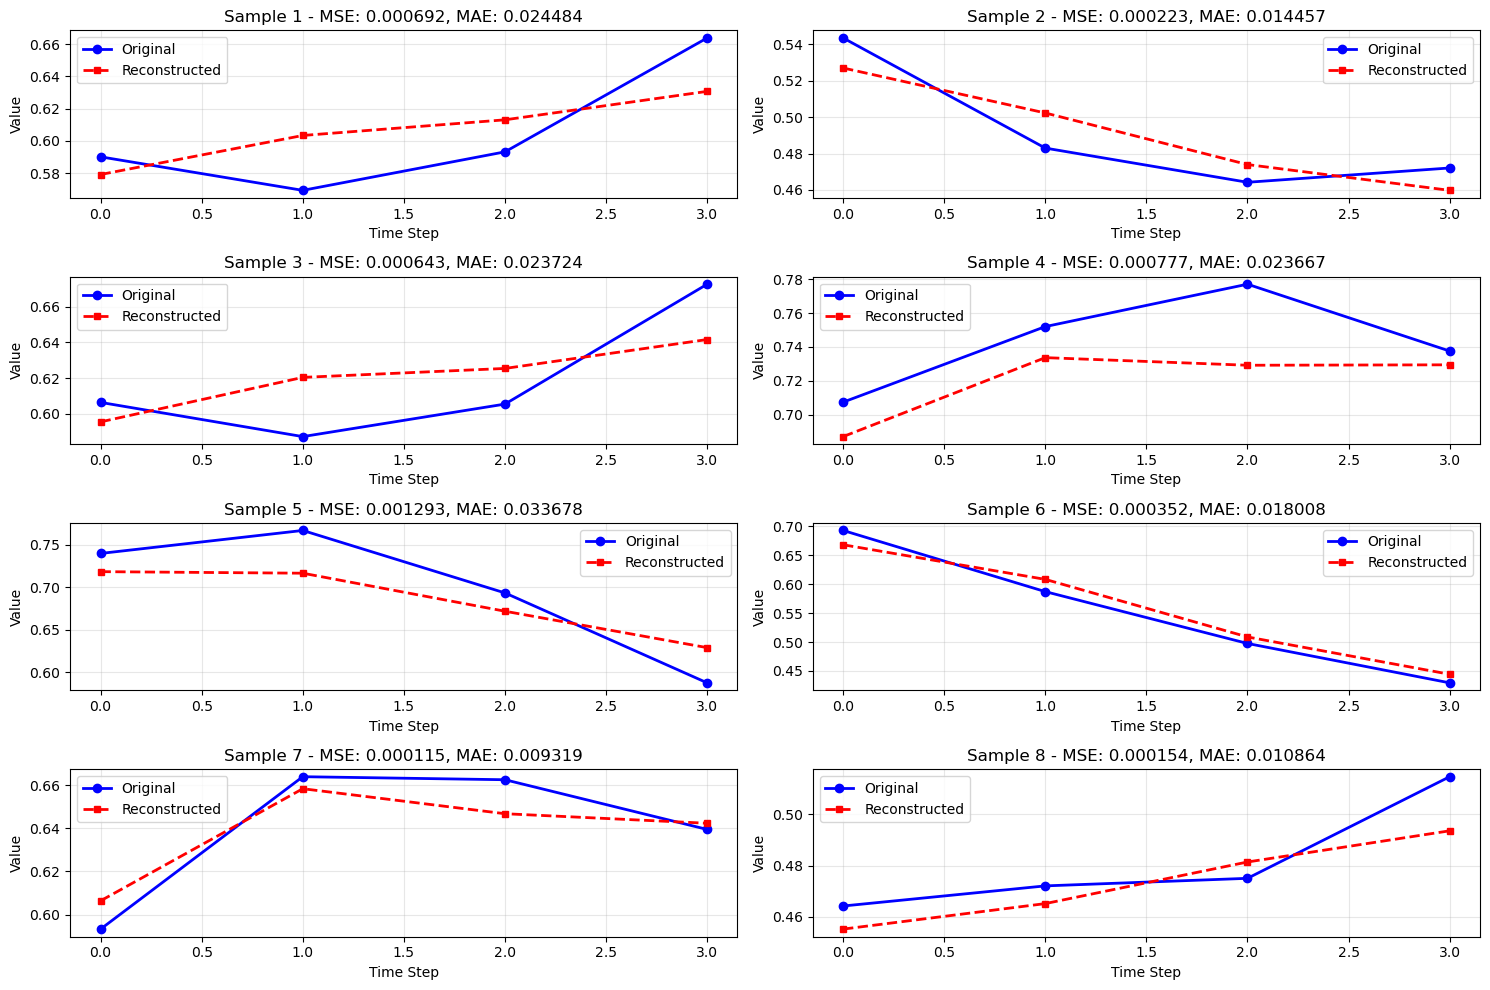

Reconstruction Statistics:
- Average MSE: 0.00053095
- Std MSE: 0.00037439
- Min MSE: 0.00011469
- Max MSE: 0.00129270


In [189]:
# Test Reconstruction Quality
def test_reconstruction_quality(enc_params, dec_params, test_samples=8):
    """Test and visualize reconstruction quality on test data"""
    
    print("Testing Reconstruction Quality...")
    print("=" * 40)
    
    reconstruction_errors = []
    
    # Create subplots
    rows = (test_samples + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(15, 2.5*rows))
    
    if rows == 1:
        if test_samples == 1:
            axes = [axes, None]
        else:
            axes = [axes] if hasattr(axes, '__len__') else [axes, None]
    else:
        axes = axes.reshape(-1) if axes.ndim == 1 else axes
    
    for i in range(test_samples):
        # Get test sample
        x_input = X_test[i]
        
        # Get reconstruction using the trained parameters
        output_raw = half_qae_circuit(enc_params, dec_params, x_input)
        
        output_scaled = []
        for o in output_raw:
            o_val = float(o) if hasattr(o, 'numpy') else o
            scaled = (o_val + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low']
            output_scaled.append(scaled)
        output_scaled = np.array(output_scaled)
        
        # Calculate reconstruction error
        mse = np.mean((x_input - output_scaled)**2)
        mae = np.mean(np.abs(x_input - output_scaled))
        reconstruction_errors.append(mse)
        
        # Plot comparison
        if rows == 1:
            ax = axes[0] if i == 0 else axes[1] if len(axes) > 1 and axes[1] is not None else axes[0]
        else:
            row = i // 2
            col = i % 2
            ax = axes[row * 2 + col] if axes.ndim == 1 else axes[row][col]
        
        if ax is not None:
            ax.plot(x_input, 'b-o', label='Original', linewidth=2, markersize=6)
            ax.plot(output_scaled, 'r--s', label='Reconstructed', linewidth=2, markersize=4)
            ax.set_title(f'Sample {i+1} - MSE: {mse:.6f}, MAE: {mae:.6f}')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Time Step')
            ax.set_ylabel('Value')
    
    # Hide unused subplots
    total_subplots = rows * 2
    for i in range(test_samples, total_subplots):
        if rows == 1:
            if len(axes) > 1 and i < len(axes) and axes[i] is not None:
                axes[i].set_visible(False)
        else:
            if axes.ndim == 1:
                if i < len(axes):
                    axes[i].set_visible(False)
            else:
                row = i // 2
                col = i % 2
                if row < axes.shape[0] and col < axes.shape[1]:
                    axes[row][col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    avg_mse = np.mean(reconstruction_errors)
    std_mse = np.std(reconstruction_errors)
    min_mse = np.min(reconstruction_errors)
    max_mse = np.max(reconstruction_errors)
    
    print(f"Reconstruction Statistics:")
    print(f"- Average MSE: {avg_mse:.8f}")
    print(f"- Std MSE: {std_mse:.8f}")
    print(f"- Min MSE: {min_mse:.8f}")
    print(f"- Max MSE: {max_mse:.8f}")
    
    return reconstruction_errors

# Test the trained model
reconstruction_errors = test_reconstruction_quality(enc_params_trained, dec_params_trained)

Analyzing Latent vs Trash Space...


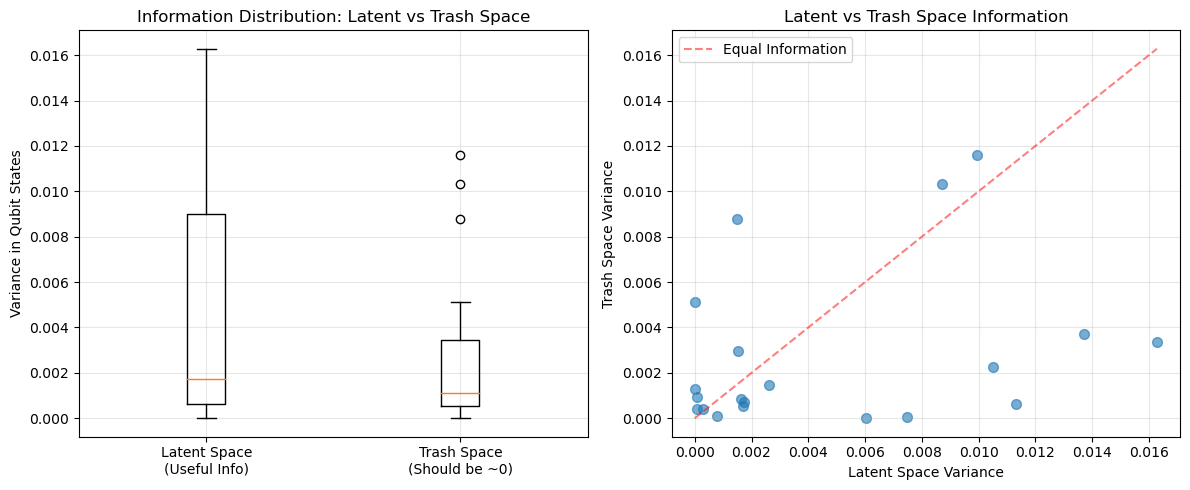

Latent Space Info - Mean: 0.004792, Std: 0.005096
Trash Space Info  - Mean: 0.002775, Std: 0.003432
Information Ratio (Latent/Trash): 1.73


In [190]:
# Analyze Latent vs Trash Space Information
@qml.qnode(dev, diff_method="backprop")
def analyze_qubit_contributions(enc_params, dec_params, x):
    """Analyze individual qubit contributions to reconstruction"""
    encoder_circuit(enc_params, x)
    decoder_circuit(dec_params)
    
    # Return individual qubit expectation values
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def latent_vs_trash_analysis(enc_params, dec_params, n_samples=20):
    """Analyze how much information is in latent vs trash space"""
    
    print("Analyzing Latent vs Trash Space...")
    print("=" * 40)
    
    latent_variations = []
    trash_variations = []
    
    for i in range(min(n_samples, len(X_test))):
        x_sample = X_test[i]
        qubit_values = analyze_qubit_contributions(enc_params, dec_params, x_sample)
        
        # Convert PennyLane tensors to numpy arrays
        qubit_values_np = [float(qv) for qv in qubit_values]
        
        # Separate latent (first n_latent qubits) and trash (remaining qubits)
        latent_values = qubit_values_np[:n_latent]
        trash_values = qubit_values_np[n_latent:]
        
        # Calculate variation (how much information each space contains)
        latent_var = np.var(latent_values) if len(latent_values) > 1 else 0
        trash_var = np.var(trash_values) if len(trash_values) > 1 else 0
        
        latent_variations.append(latent_var)
        trash_variations.append(trash_var)
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    if len(latent_variations) > 0 and len(trash_variations) > 0:
        plt.boxplot([latent_variations, trash_variations], 
                    labels=['Latent Space\n(Useful Info)', 'Trash Space\n(Should be ~0)'])
        plt.ylabel('Variance in Qubit States')
        plt.title('Information Distribution: Latent vs Trash Space')
        plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    if len(latent_variations) > 0 and len(trash_variations) > 0:
        plt.scatter(latent_variations, trash_variations, alpha=0.6, s=50)
        plt.xlabel('Latent Space Variance')
        plt.ylabel('Trash Space Variance')
        plt.title('Latent vs Trash Space Information')
        plt.grid(True, alpha=0.3)
        
        # Add diagonal line for reference
        max_val = max(max(latent_variations) if latent_variations else 0, 
                     max(trash_variations) if trash_variations else 0)
        if max_val > 0:
            plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Equal Information')
            plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    if latent_variations and trash_variations:
        latent_mean = np.mean(latent_variations)
        trash_mean = np.mean(trash_variations)
        
        print(f"Latent Space Info - Mean: {latent_mean:.6f}, Std: {np.std(latent_variations):.6f}")
        print(f"Trash Space Info  - Mean: {trash_mean:.6f}, Std: {np.std(trash_variations):.6f}")
        
        if trash_mean > 0:
            ratio = latent_mean / trash_mean
            print(f"Information Ratio (Latent/Trash): {ratio:.2f}")
        else:
            print(f"Information Ratio (Latent/Trash): ∞ (trash space ≈ 0)")
    
    return latent_variations, trash_variations

# Analyze the trained model
latent_info, trash_info = latent_vs_trash_analysis(enc_params_trained, dec_params_trained)

In [191]:
# Save the Trained Half-QAE Model
def save_trained_model(enc_params, dec_params, train_history, reconstruction_errors):
    """Save the trained half-QAE model and results"""
    
    # Convert PennyLane tensors
    enc_params_list = [float(p) for p in enc_params]
    dec_params_list = [float(p) for p in dec_params]
    train_costs_list = [float(c) for c in train_history]
    reconstruction_errors_list = [float(e) for e in reconstruction_errors]
    
    model_data = {
        # Model architecture
        'n_qubits': n_qubits,
        'n_latent': n_latent,
        'n_trash': n_trash,
        'n_layers': n_layers,
        
        # Training parameters
        'n_epochs': len(train_history),
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        
        # Trained parameters
        'enc_params': enc_params_list,
        'dec_params': dec_params_list,
        
        # Training history
        'train_costs': train_costs_list,
        
        # Performance metrics
        'final_train_cost': float(train_history[-1]),
        'avg_reconstruction_error': float(np.mean(reconstruction_errors)),
        'reconstruction_errors': reconstruction_errors_list,
        
        # Data information
        'data_info': info,
        'training_samples': len(X_train),
        'test_samples': len(X_test)
    }
    
    # Save model
    model_path = f'{DATA_PATH}/{data_folder}/half_qae_replicating_model.json'
    with open(model_path, 'w') as f:
        json.dump(model_data, f, indent=2)
    
    print(f"Trained Half-QAE model saved to: {model_path}")
    
    return model_path

# Save the trained model
model_file = save_trained_model(
    enc_params_trained, 
    dec_params_trained, 
    train_history, 
    reconstruction_errors
)

# Final Model Assessment
print("=" * 60)
print("HALF-QAE REPLICATING MODEL - FINAL ASSESSMENT")
print("=" * 60)

print(f"✓ Model Architecture: {n_qubits} qubits ({n_latent} latent + {n_trash} trash)")
print(f"✓ Training completed in {len(train_history)} epochs")
print(f"✓ Final training cost: {train_history[-1]:.8f}")
print(f"✓ Average reconstruction error: {np.mean(reconstruction_errors):.8f}")

if np.mean(reconstruction_errors) < 0.001:
    print("✓ EXCELLENT: Near-perfect reconstruction achieved!")
    print("  → Ready for symmetric full-QAE implementation")
    print("  → Trash space should be minimal")
elif np.mean(reconstruction_errors) < 0.01:
    print("✓ GOOD: Reasonable reconstruction quality")
    print("  → Consider more training epochs or architecture tuning")
else:
    print("⚠ NEEDS IMPROVEMENT: High reconstruction error")
    print("  → Consider increasing model complexity or training time")

print("\n" + "=" * 60)
print("NEXT STEPS:")
print("1. Use trained encoder weights for symmetric full-QAE")
print("2. Mirror encoder parameters to create decoder for full-QAE") 
print("3. Experiment with latent/trash space balance")
print("4. Test noise reduction with noisy→pure data mapping")
print("=" * 60)

Trained Half-QAE model saved to: aintern/data/mackey_glass_n100/half_qae_replicating_model.json
HALF-QAE REPLICATING MODEL - FINAL ASSESSMENT
✓ Model Architecture: 4 qubits (2 latent + 2 trash)
✓ Training completed in 100 epochs
✓ Final training cost: 0.00040434
✓ Average reconstruction error: 0.00053095
✓ EXCELLENT: Near-perfect reconstruction achieved!
  → Ready for symmetric full-QAE implementation
  → Trash space should be minimal

NEXT STEPS:
1. Use trained encoder weights for symmetric full-QAE
2. Mirror encoder parameters to create decoder for full-QAE
3. Experiment with latent/trash space balance
4. Test noise reduction with noisy→pure data mapping


COMPREHENSIVE RECONSTRUCTION ANALYSIS
Analyzing 20 samples (requested: 20, available: 20)


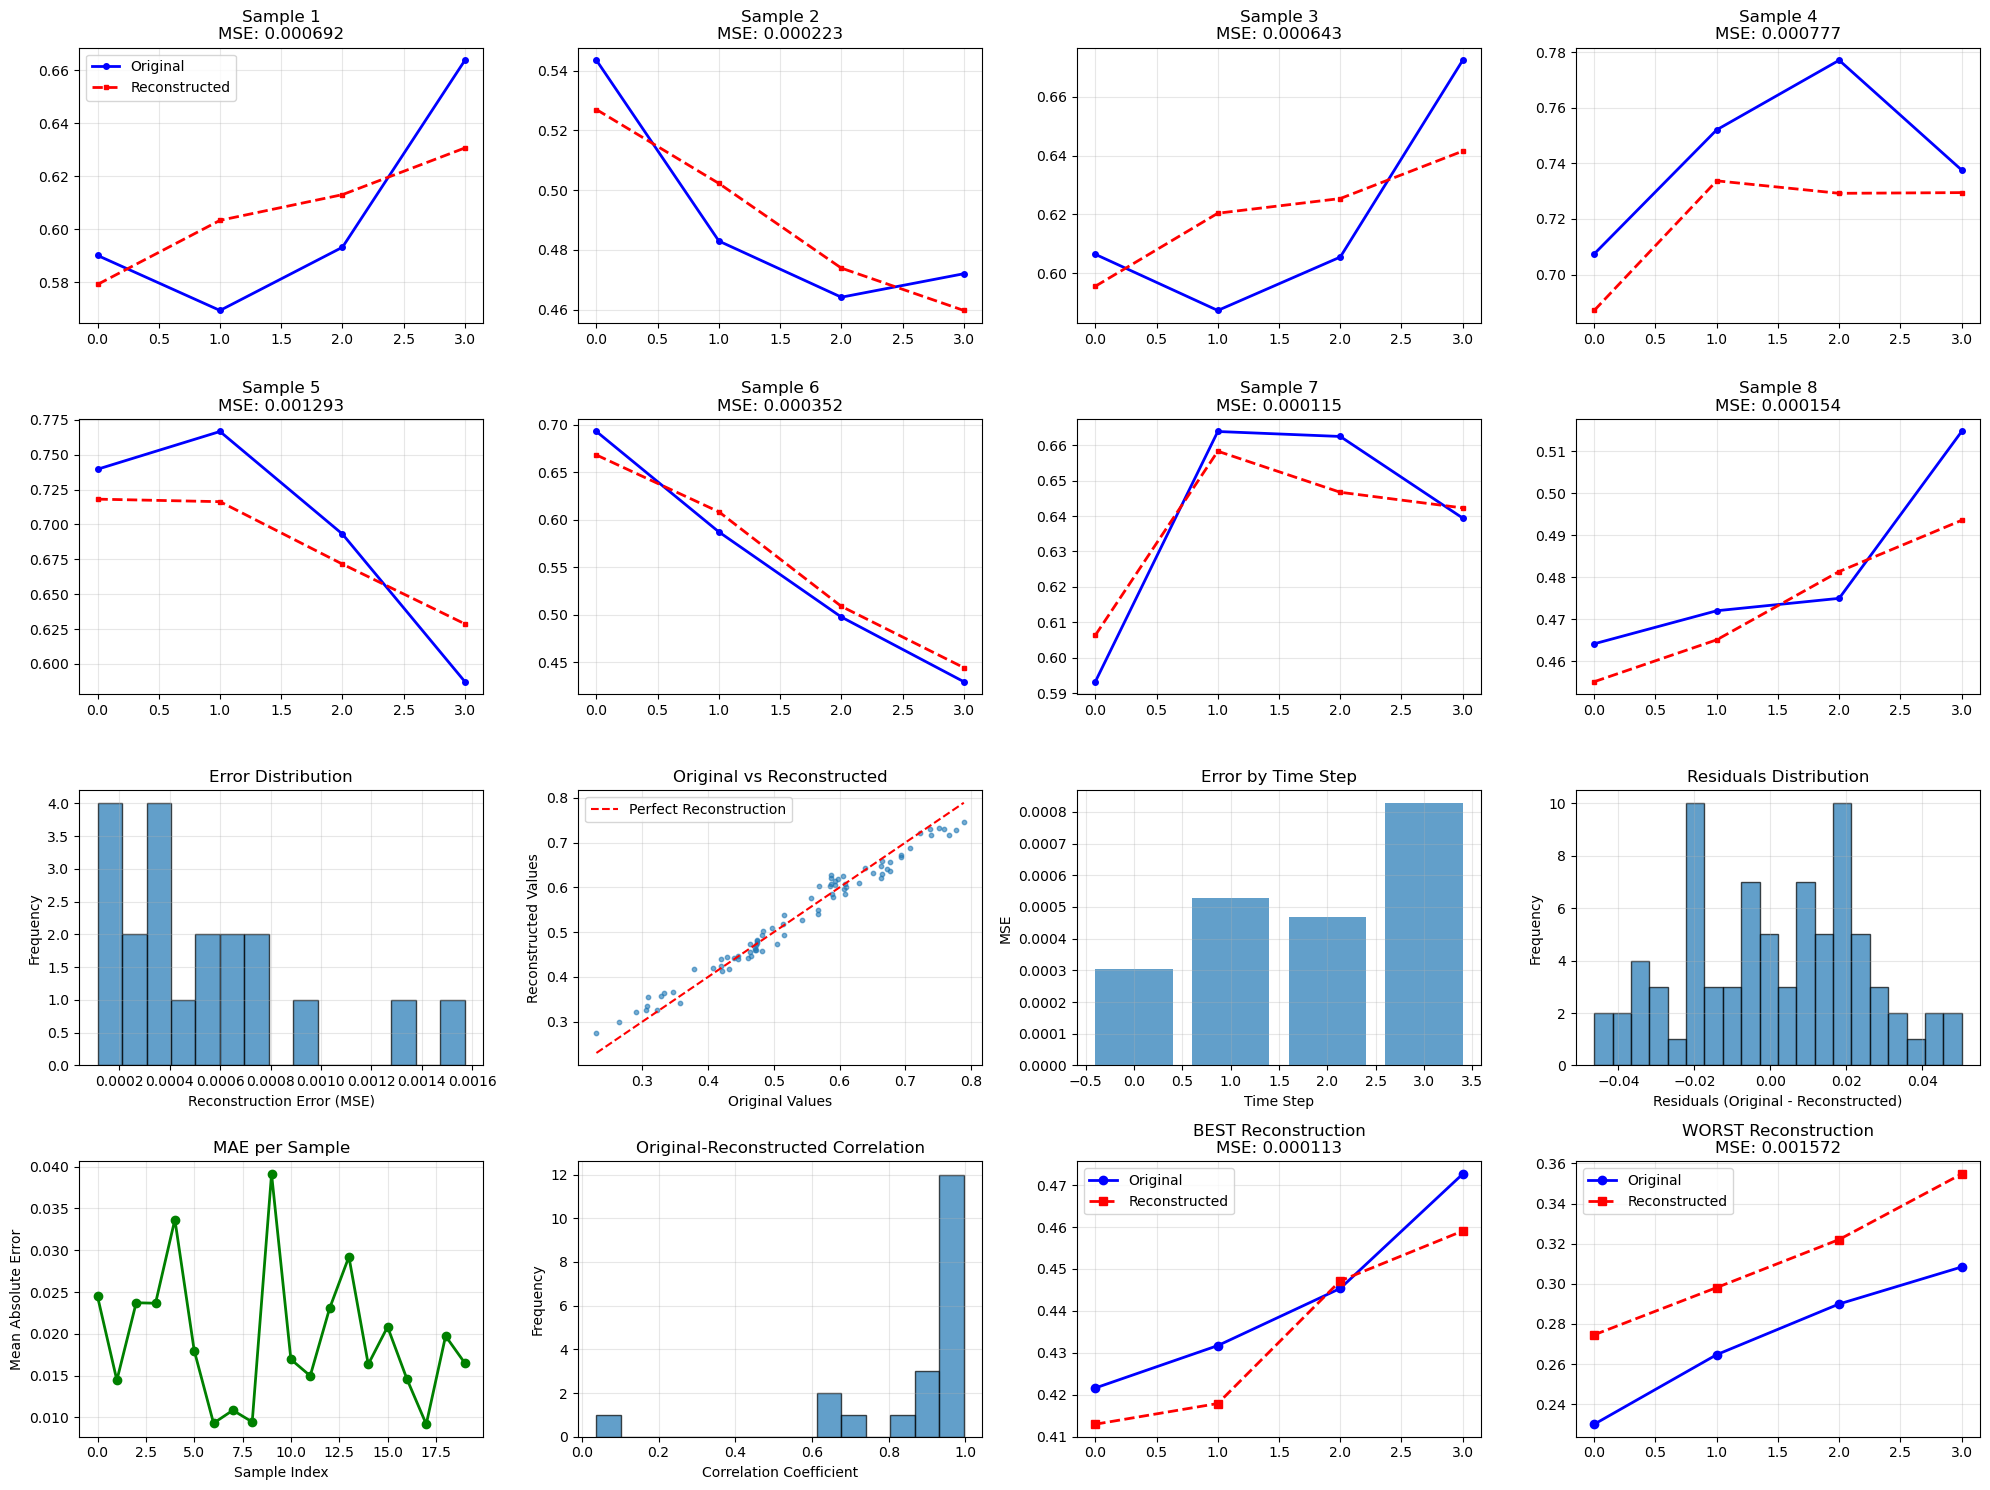


STATISTICAL ANALYSIS:
----------------------------------------
Number of samples analyzed: 20
Data points per sample: 4
Total data points: 80

RECONSTRUCTION ERRORS:
- Mean MSE: 0.00053209
- Std MSE: 0.00038097
- Min MSE: 0.00011344
- Max MSE: 0.00157152
- Median MSE: 0.00043316

MEAN ABSOLUTE ERRORS:
- Mean MAE: 0.01941159
- Std MAE: 0.00786593
- Min MAE: 0.00919629
- Max MAE: 0.03912447

CORRELATION ANALYSIS:
- Mean Correlation: 0.857095
- Std Correlation: 0.219800
- Min Correlation: 0.037814
- Max Correlation: 0.995734

DATA RANGE ANALYSIS:
- Original data range: 0.559063
- Reconstructed data range: 0.470786
- Range preservation: 84.21%

QUALITY ASSESSMENT:
- Excellent reconstructions (MSE < 0.0001): 0/20 (0.0%)
- Good reconstructions (MSE < 0.001): 18/20 (90.0%)
- Poor reconstructions (MSE ≥ 0.001): 2/20 (10.0%)


In [192]:
# Comprehensive Data vs Reconstruction Comparison - FIXED
def comprehensive_reconstruction_analysis(enc_params, dec_params, n_samples=20):
    """Comprehensive analysis comparing original data vs reconstructed data"""
    
    print("COMPREHENSIVE RECONSTRUCTION ANALYSIS")
    print("=" * 60)
    
    actual_samples = min(n_samples, len(X_test))
    print(f"Analyzing {actual_samples} samples (requested: {n_samples}, available: {len(X_test)})")
    
    # Test on multiple samples
    reconstruction_errors = []
    original_data = []
    reconstructed_data = []
    
    for i in range(actual_samples):
        x_input = X_test[i]
        
        # Get reconstruction
        output_raw = half_qae_circuit(enc_params, dec_params, x_input)
        
        # Scale back to original range
        output_scaled = []
        for o in output_raw:
            o_val = float(o) if hasattr(o, 'numpy') else o
            scaled = (o_val + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low']
            output_scaled.append(scaled)
        output_scaled = np.array(output_scaled)
        
        # Store data
        original_data.append(x_input)
        reconstructed_data.append(output_scaled)
        
        # Calculate errors
        mse = np.mean((x_input - output_scaled)**2)
        reconstruction_errors.append(mse)
    
    original_data = np.array(original_data)
    reconstructed_data = np.array(reconstructed_data)
    reconstruction_errors = np.array(reconstruction_errors)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Sample-by-sample comparison (first 8 samples)
    for i in range(min(8, actual_samples)):
        plt.subplot(4, 4, i + 1)
        plt.plot(original_data[i], 'b-o', label='Original', linewidth=2, markersize=4)
        plt.plot(reconstructed_data[i], 'r--s', label='Reconstructed', linewidth=2, markersize=3)
        plt.title(f'Sample {i+1}\nMSE: {reconstruction_errors[i]:.6f}')
        plt.grid(True, alpha=0.3)
        if i == 0:
            plt.legend()
    
    # 2. Error distribution
    plt.subplot(4, 4, 9)
    plt.hist(reconstruction_errors, bins=15, alpha=0.7, edgecolor='black')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.grid(True, alpha=0.3)
    
    # 3. Original vs Reconstructed scatter plot
    plt.subplot(4, 4, 10)
    plt.scatter(original_data.flatten(), reconstructed_data.flatten(), alpha=0.6, s=10)
    min_val = min(original_data.min(), reconstructed_data.min())
    max_val = max(original_data.max(), reconstructed_data.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Reconstruction')
    plt.xlabel('Original Values')
    plt.ylabel('Reconstructed Values')
    plt.title('Original vs Reconstructed')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Reconstruction quality over time steps
    plt.subplot(4, 4, 11)
    timestep_errors = []
    for t in range(n_qubits):
        timestep_mse = np.mean((original_data[:, t] - reconstructed_data[:, t])**2)
        timestep_errors.append(timestep_mse)
    plt.bar(range(n_qubits), timestep_errors, alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel('MSE')
    plt.title('Error by Time Step')
    plt.grid(True, alpha=0.3)
    
    # 5. Residuals analysis
    plt.subplot(4, 4, 12)
    residuals = (original_data - reconstructed_data).flatten()
    plt.hist(residuals, bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Residuals (Original - Reconstructed)')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')
    plt.grid(True, alpha=0.3)
    
    # 6. Mean absolute error by sample
    plt.subplot(4, 4, 13)
    mae_errors = [np.mean(np.abs(original_data[i] - reconstructed_data[i])) for i in range(actual_samples)]  # Use actual_samples
    plt.plot(mae_errors, 'go-', linewidth=2)
    plt.xlabel('Sample Index')
    plt.ylabel('Mean Absolute Error')
    plt.title('MAE per Sample')
    plt.grid(True, alpha=0.3)
    
    # 7. Correlation analysis
    plt.subplot(4, 4, 14)
    correlations = []
    for i in range(actual_samples):
        corr = np.corrcoef(original_data[i], reconstructed_data[i])[0, 1]
        correlations.append(corr)
    plt.hist(correlations, bins=15, alpha=0.7, edgecolor='black')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.title('Original-Reconstructed Correlation')
    plt.grid(True, alpha=0.3)
    
    # 8. Best and worst reconstructions
    best_idx = np.argmin(reconstruction_errors)
    worst_idx = np.argmax(reconstruction_errors)
    
    plt.subplot(4, 4, 15)
    plt.plot(original_data[best_idx], 'b-o', label='Original', linewidth=2)
    plt.plot(reconstructed_data[best_idx], 'r--s', label='Reconstructed', linewidth=2)
    plt.title(f'BEST Reconstruction\nMSE: {reconstruction_errors[best_idx]:.6f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(4, 4, 16)
    plt.plot(original_data[worst_idx], 'b-o', label='Original', linewidth=2)
    plt.plot(reconstructed_data[worst_idx], 'r--s', label='Reconstructed', linewidth=2)
    plt.title(f'WORST Reconstruction\nMSE: {reconstruction_errors[worst_idx]:.6f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical Analysis
    print("\nSTATISTICAL ANALYSIS:")
    print("-" * 40)
    print(f"Number of samples analyzed: {actual_samples}")
    print(f"Data points per sample: {n_qubits}")
    print(f"Total data points: {actual_samples * n_qubits}")
    
    print(f"\nRECONSTRUCTION ERRORS:")
    print(f"- Mean MSE: {np.mean(reconstruction_errors):.8f}")
    print(f"- Std MSE: {np.std(reconstruction_errors):.8f}")
    print(f"- Min MSE: {np.min(reconstruction_errors):.8f}")
    print(f"- Max MSE: {np.max(reconstruction_errors):.8f}")
    print(f"- Median MSE: {np.median(reconstruction_errors):.8f}")
    
    mae_errors = np.array(mae_errors)
    print(f"\nMEAN ABSOLUTE ERRORS:")
    print(f"- Mean MAE: {np.mean(mae_errors):.8f}")
    print(f"- Std MAE: {np.std(mae_errors):.8f}")
    print(f"- Min MAE: {np.min(mae_errors):.8f}")
    print(f"- Max MAE: {np.max(mae_errors):.8f}")
    
    correlations = np.array(correlations)
    print(f"\nCORRELATION ANALYSIS:")
    print(f"- Mean Correlation: {np.mean(correlations):.6f}")
    print(f"- Std Correlation: {np.std(correlations):.6f}")
    print(f"- Min Correlation: {np.min(correlations):.6f}")
    print(f"- Max Correlation: {np.max(correlations):.6f}")
    
    # Data range analysis
    orig_range = original_data.max() - original_data.min()
    recon_range = reconstructed_data.max() - reconstructed_data.min()
    print(f"\nDATA RANGE ANALYSIS:")
    print(f"- Original data range: {orig_range:.6f}")
    print(f"- Reconstructed data range: {recon_range:.6f}")
    print(f"- Range preservation: {(recon_range/orig_range*100):.2f}%")
    

    good_threshold = 0.001
    excellent_threshold = 0.0001 
    
    good_count = np.sum(reconstruction_errors < good_threshold)
    excellent_count = np.sum(reconstruction_errors < excellent_threshold)
    
    print(f"\nQUALITY ASSESSMENT:")
    print(f"- Excellent reconstructions (MSE < {excellent_threshold}): {excellent_count}/{actual_samples} ({excellent_count/actual_samples*100:.1f}%)")
    print(f"- Good reconstructions (MSE < {good_threshold}): {good_count}/{actual_samples} ({good_count/actual_samples*100:.1f}%)")
    print(f"- Poor reconstructions (MSE ≥ {good_threshold}): {actual_samples-good_count}/{actual_samples} ({(actual_samples-good_count)/actual_samples*100:.1f}%)")
    
    return {
        'reconstruction_errors': reconstruction_errors,
        'mae_errors': mae_errors,
        'correlations': correlations,
        'original_data': original_data,
        'reconstructed_data': reconstructed_data,
        'best_sample_idx': best_idx,
        'worst_sample_idx': worst_idx
    }

# Run comprehensive analysis with the available test samples
analysis_results = comprehensive_reconstruction_analysis(enc_params_trained, dec_params_trained, n_samples=len(X_test))


DETAILED SAMPLE ANALYSIS
Sample 0:
  Original:      [0.59016348 0.56938566 0.59325626 0.66385414]
  Reconstructed: [0.57920924 0.6034036  0.61311048 0.63074348]
  MSE: 0.00069193, MAE: 0.02448426
  RMSE: 0.02630457, Correlation: 0.702311
  Point-wise errors: [0.01095424 0.03401794 0.01985422 0.03311066]
------------------------------
Sample 5:
  Original:      [0.69306326 0.58724342 0.49758428 0.42944527]
  Reconstructed: [0.6683134  0.60844022 0.50884069 0.44427354]
  MSE: 0.00035211, MAE: 0.01800784
  RMSE: 0.01876463, Correlation: 0.990000
  Point-wise errors: [0.02474986 0.0211968  0.01125641 0.01482827]
------------------------------
Sample 10:
  Original:      [0.60930892 0.59715014 0.58499157 0.62984716]
  Reconstructed: [0.60181602 0.6184269  0.60399584 0.60981708]
  MSE: 0.00031780, MAE: 0.01695100
  RMSE: 0.01782702, Correlation: 0.037814
  Point-wise errors: [0.0074929  0.02127676 0.01900427 0.02003008]
------------------------------
Sample 15:
  Original:      [0.32181567 

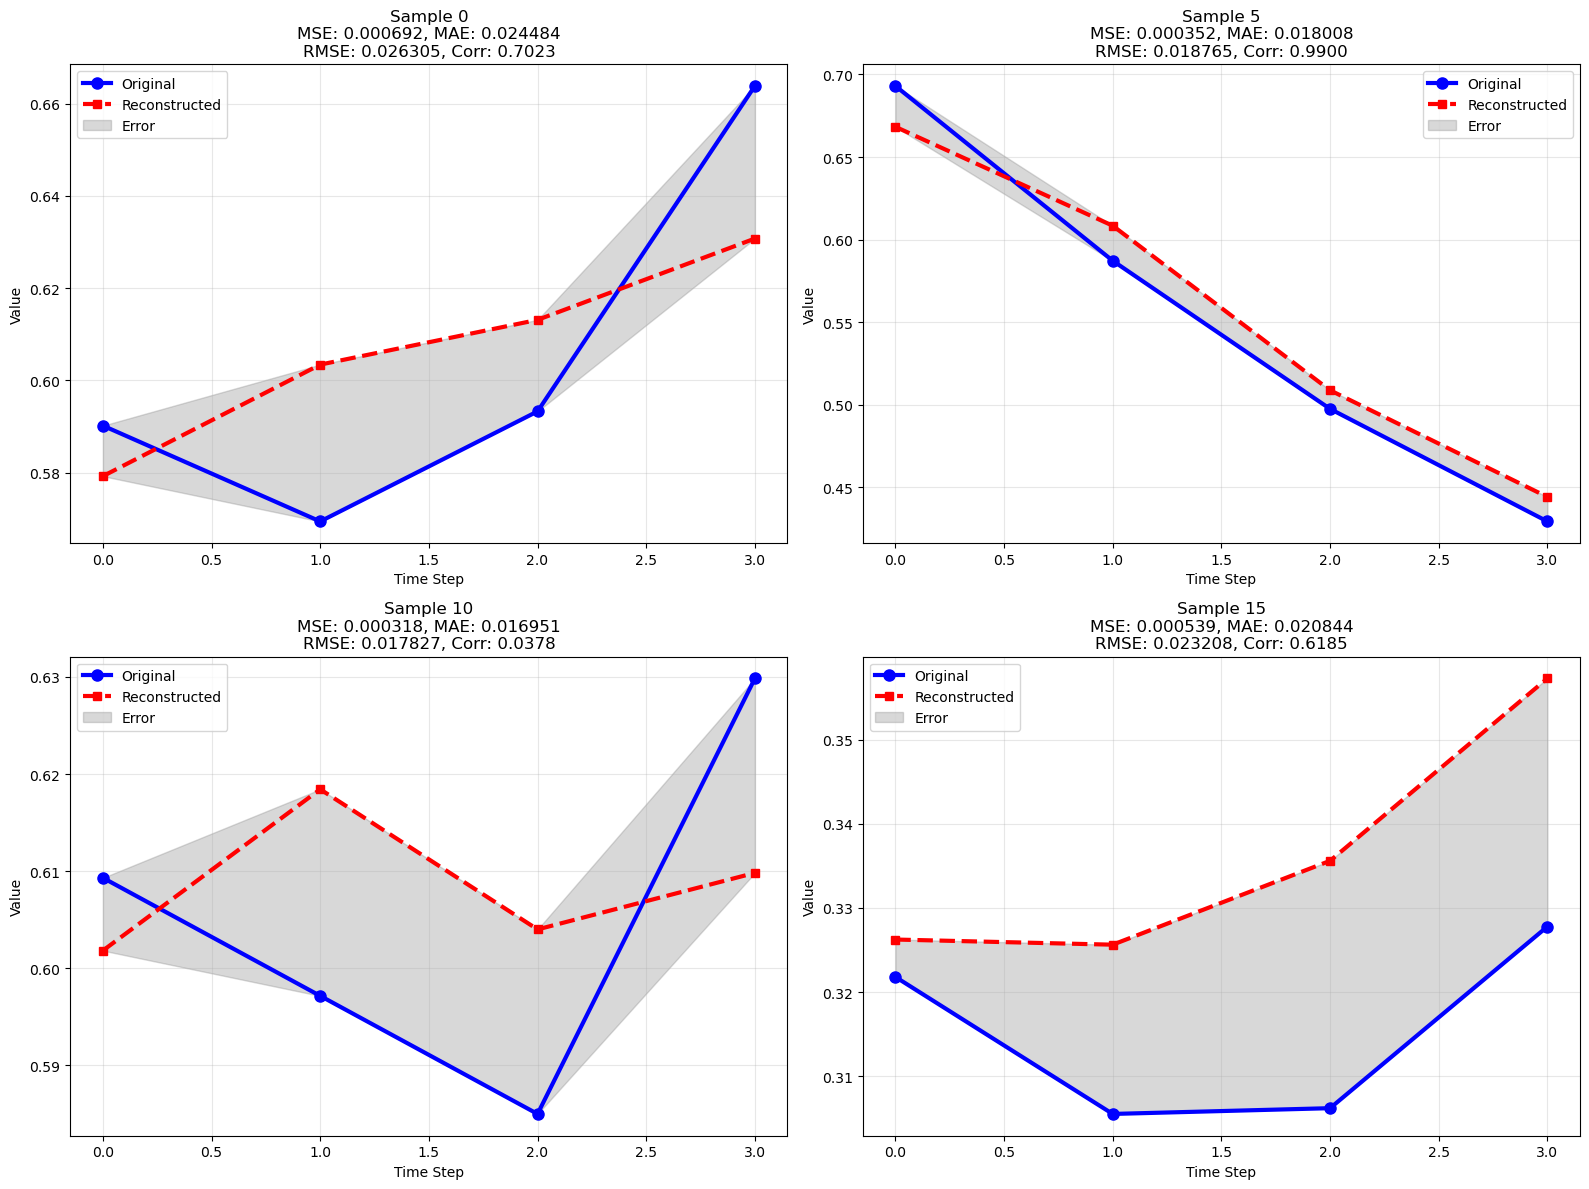

In [185]:
# Additional Detailed Sample Analysis
def detailed_sample_analysis(enc_params, dec_params, sample_indices=[0, 5, 10, 15]):
    """Detailed analysis of specific samples"""
    
    print("\nDETAILED SAMPLE ANALYSIS")
    print("=" * 50)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, sample_idx in enumerate(sample_indices):
        if sample_idx >= len(X_test):
            continue
            
        x_input = X_test[sample_idx]
        output_raw = half_qae_circuit(enc_params, dec_params, x_input)
        
        # Scale back to original range
        output_scaled = []
        for o in output_raw:
            o_val = float(o) if hasattr(o, 'numpy') else o
            scaled = (o_val + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low']
            output_scaled.append(scaled)
        output_scaled = np.array(output_scaled)
        
        # Calculate metrics
        mse = np.mean((x_input - output_scaled)**2)
        mae = np.mean(np.abs(x_input - output_scaled))
        rmse = np.sqrt(mse)
        correlation = np.corrcoef(x_input, output_scaled)[0, 1]
        
        # Plot
        ax = axes[idx]
        ax.plot(x_input, 'b-o', label='Original', linewidth=3, markersize=8)
        ax.plot(output_scaled, 'r--s', label='Reconstructed', linewidth=3, markersize=6)
        
        # Add error bars
        errors = np.abs(x_input - output_scaled)
        ax.fill_between(range(len(x_input)), 
                       np.minimum(x_input, output_scaled), 
                       np.maximum(x_input, output_scaled), 
                       alpha=0.3, color='gray', label='Error')
        
        ax.set_title(f'Sample {sample_idx}\nMSE: {mse:.6f}, MAE: {mae:.6f}\nRMSE: {rmse:.6f}, Corr: {correlation:.4f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        
        print(f"Sample {sample_idx}:")
        print(f"  Original:      {x_input}")
        print(f"  Reconstructed: {output_scaled}")
        print(f"  MSE: {mse:.8f}, MAE: {mae:.8f}")
        print(f"  RMSE: {rmse:.8f}, Correlation: {correlation:.6f}")
        print(f"  Point-wise errors: {errors}")
        print("-" * 30)
    
    plt.tight_layout()
    plt.show()

# Run detailed sample analysis
detailed_sample_analysis(enc_params_trained, dec_params_trained)

Creating Comprehensive Comparison Plot...
Processing 20 training samples...
Processing 20 test samples...


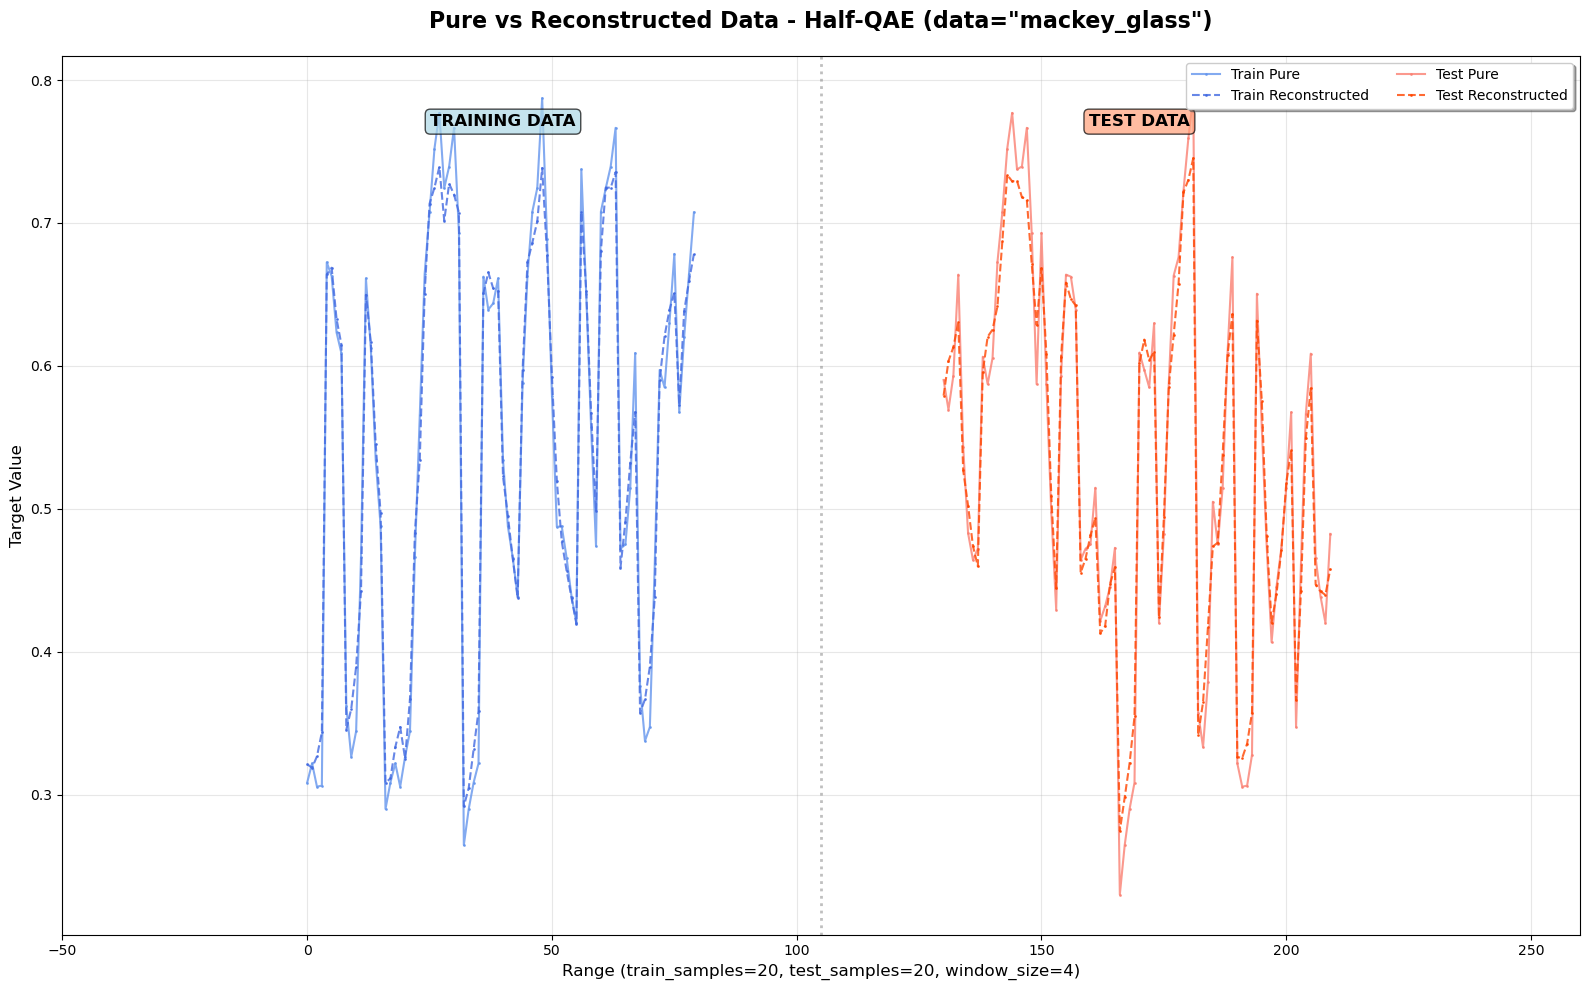


COMPREHENSIVE COMPARISON STATISTICS
Training Data:
  - Samples: 20 windows (80 data points)
  - MSE: 0.00047546
  - Correlation: 0.992707
  - Data Range: [0.2647, 0.7874]

Test Data:
  - Samples: 20 windows (80 data points)
  - MSE: 0.00053209
  - Correlation: 0.989092
  - Data Range: [0.2300, 0.7891]

Overall Performance:
  - Average MSE: 0.00050377
  - Average Correlation: 0.990900
  - Status: EXCELLENT - High-quality reconstruction!


In [195]:
# Full Comparison Plot
def create_comprehensive_comparison_plot(enc_params, dec_params, n_samples=100):
    """Create a comprehensive comparison plot similar to the reference image"""
    
    print("Creating Comprehensive Comparison Plot...")
    print("=" * 50)
    
    actual_samples = min(n_samples, len(X_train), len(X_test))

    train_original = []
    train_reconstructed = []
    
    print(f"Processing {actual_samples} training samples...")
    for i in range(actual_samples):
        x_input = X_train[i]
        
        output_raw = half_qae_circuit(enc_params, dec_params, x_input)
        
        output_scaled = []
        for o in output_raw:
            o_val = float(o) if hasattr(o, 'numpy') else o
            scaled = (o_val + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low']
            output_scaled.append(scaled)
        
        train_original.extend(x_input)
        train_reconstructed.extend(output_scaled)
    
    test_original = []
    test_reconstructed = []
    
    print(f"Processing {len(X_test)} test samples...")
    for i in range(len(X_test)):
        x_input = X_test[i]
        
        output_raw = half_qae_circuit(enc_params, dec_params, x_input)

        output_scaled = []
        for o in output_raw:
            o_val = float(o) if hasattr(o, 'numpy') else o
            scaled = (o_val + 1) / 2 * (info['scale_high'] - info['scale_low']) + info['scale_low']
            output_scaled.append(scaled)
        
        test_original.extend(x_input)
        test_reconstructed.extend(output_scaled)
    
    plt.figure(figsize=(16, 10))
    
    train_range = range(len(train_original))
    test_start = len(train_original) + 50  
    test_range = range(test_start, test_start + len(test_original))
    

    plt.plot(train_range, train_original, 
             color='cornflowerblue', linestyle='-', marker='.', markersize=2,
             label='Train Pure', linewidth=1.5, alpha=0.8)
    
    plt.plot(train_range, train_reconstructed, 
             color='royalblue', linestyle='--', marker='.', markersize=2,
             label='Train Reconstructed', linewidth=1.5, alpha=0.8)
    
    plt.plot(test_range, test_original, 
             color='salmon', linestyle='-', marker='.', markersize=2,
             label='Test Pure', linewidth=1.5, alpha=0.8)
    
    plt.plot(test_range, test_reconstructed, 
             color='orangered', linestyle='--', marker='.', markersize=2,
             label='Test Reconstructed', linewidth=1.5, alpha=0.8)
    
    separator_x = len(train_original) + 25
    plt.axvline(x=separator_x, color='gray', linestyle=':', alpha=0.5, linewidth=2)
    
    plt.text(len(train_original)//2, plt.ylim()[1]*0.95, 'TRAINING DATA', 
             ha='center', va='top', fontsize=12, fontweight='bold', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    plt.text(test_start + len(test_original)//2, plt.ylim()[1]*0.95, 'TEST DATA', 
             ha='center', va='top', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightsalmon", alpha=0.7))
    
    plt.title(f'Pure vs Reconstructed Data - Half-QAE (data="mackey_glass")', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(f'Range (train_samples={actual_samples}, test_samples={len(X_test)}, window_size={n_qubits})', 
               fontsize=12)
    plt.ylabel('Target Value', fontsize=12)
    plt.legend(ncol=2, loc='upper right', frameon=True, fancybox=True, shadow=True)
    plt.grid(True, alpha=0.3)
    
    plt.xlim(-50, test_start + len(test_original) + 50)
    
    plt.tight_layout()
    plt.show()
    
    train_mse = np.mean((np.array(train_original) - np.array(train_reconstructed))**2)
    test_mse = np.mean((np.array(test_original) - np.array(test_reconstructed))**2)
    
    train_corr = np.corrcoef(train_original, train_reconstructed)[0, 1]
    test_corr = np.corrcoef(test_original, test_reconstructed)[0, 1]
    
    print("\n" + "="*60)
    print("COMPREHENSIVE COMPARISON STATISTICS")
    print("="*60)
    print(f"Training Data:")
    print(f"  - Samples: {actual_samples} windows ({actual_samples * n_qubits} data points)")
    print(f"  - MSE: {train_mse:.8f}")
    print(f"  - Correlation: {train_corr:.6f}")
    print(f"  - Data Range: [{min(train_original):.4f}, {max(train_original):.4f}]")
    
    print(f"\nTest Data:")
    print(f"  - Samples: {len(X_test)} windows ({len(X_test) * n_qubits} data points)")
    print(f"  - MSE: {test_mse:.8f}")
    print(f"  - Correlation: {test_corr:.6f}")
    print(f"  - Data Range: [{min(test_original):.4f}, {max(test_original):.4f}]")
    
    print(f"\nOverall Performance:")
    overall_mse = (train_mse + test_mse) / 2
    overall_corr = (train_corr + test_corr) / 2
    print(f"  - Average MSE: {overall_mse:.8f}")
    print(f"  - Average Correlation: {overall_corr:.6f}")
    
    if overall_mse < 0.001 and overall_corr > 0.9:
        print("  - Status: EXCELLENT - High-quality reconstruction!")
    elif overall_mse < 0.01 and overall_corr > 0.7:
        print("  - Status: GOOD - Reasonable reconstruction quality")
    else:
        print("  - Status: NEEDS IMPROVEMENT - Consider model tuning")
    
    print("="*60)
    
    return {
        'train_original': train_original,
        'train_reconstructed': train_reconstructed,
        'test_original': test_original,
        'test_reconstructed': test_reconstructed,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_correlation': train_corr,
        'test_correlation': test_corr
    }

comparison_results = create_comprehensive_comparison_plot(
    enc_params_trained, 
    dec_params_trained, 
    n_samples=100
)